# **NN RECOMMENDER SYSTEM**

Here we start by importing libraries for getting the data.

Actually, I used data by uploading Google Colab from my laptop, 
because of my laptop's lack of ram.

Therefore, in order to be consistent and provide integrity in the code when you run, I searched and find this small downloading code to download Movielens 1M dataset. 

Here are the download code's imports:

In [ ]:

import io
import os
import math
import copy
import pickle
import zipfile
from textwrap import wrap
from pathlib import Path
from itertools import zip_longest
from collections import defaultdict
from urllib.error import URLError
from urllib.request import urlopen
from zipfile import ZipFile

import numpy as np
import pandas as pd

Data download code starts here:

In [ ]:

def try_download(url, download_path):
    archive_name = url.split('/')[-1]
    folder_name, _ = os.path.splitext(archive_name)
    
    try:
        r = urlopen(url)
    except URLError as e:
        print('Cannot download the data. Error: %s' % s)
        return 

    assert r.status == 200
    data = r.read()

    with zipfile.ZipFile(io.BytesIO(data)) as arch:
        arch.extractall(download_path)
        
    print('The archive is extracted into folder: %s' % download_path)

# It also includes reading the data
def read_data(path):
    files = {}
    for filename in path.glob('*'):
        if filename.suffix == '.csv':
            files[filename.stem] = pd.read_csv(filename)
        elif filename.suffix == '.dat':
            if filename.stem == 'ratings':
                columns = ['userId', 'movieId', 'rating', 'timestamp']
            else:
                columns = ['movieId', 'title', 'genres']
            data = pd.read_csv(filename, sep='::', names=columns, engine='python')
            files[filename.stem] = data
    return files['ratings'], files['movies']

In [ ]:
# 1M Movielens dataset URL
archive_url = f'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
download_path = Path.home() / 'data' / 'movielens'

# Download dataset
try_download(archive_url, download_path)

# Pick one of the available folders and we are done
ratings, movies = read_data(download_path /'ml-1m')

The archive is extracted into folder: /root/data/movielens


Let's quickly check what we have in the dataset:


In [ ]:
ratings.sample(5)

,userId,movieId,rating,timestamp
449581,2772,1127,3,973094273
948970,5733,2105,5,958430698
542233,3336,2150,2,968096307
11310,86,904,5,977706640
152054,977,2916,4,975109962


In [ ]:
movies.sample(5)

,movieId,title,genres
1769,1837,"Odd Couple II, The (1998)",Comedy
1697,1749,"Leading Man, The (1996)",Romance
3213,3282,Different for Girls (1996),Comedy
1723,1781,"Further Gesture, A (1996)",Drama
150,152,"Addiction, The (1995)",Horror


In [ ]:
print('There are {} rows of data from {} users'.format(len(ratings), len(ratings.userId.unique())))

There are 1000209 rows of data from 6040 users


Let's do some preprocessing for out data.

Prepare it as df and encode users and movies as integer indices.

Here we used sklearn's LabelEncoder for this process.

In [ ]:
from sklearn.preprocessing import LabelEncoder

def create_df(df):

    # Encoding users and movies as integers
    user_enc = LabelEncoder()
    df['user'] = user_enc.fit_transform(df['userId'].values)
    
    item_enc = LabelEncoder()
    df['movie'] = item_enc.fit_transform(df['movieId'].values)

    # Number of unique users and movies
    n_users = df['user'].nunique()
    n_movies = df['movie'].nunique()

    df['rating'] = df['rating'].values.astype(np.float32)

    # Min and Max ratings from the database
    # We will use these for normalization
    min_rating = min(df['rating'])
    max_rating = max(df['rating'])

    return n_users, n_movies, min_rating, max_rating, df



In [ ]:
from sklearn.model_selection import train_test_split

# Create our df by calling create_df function & create X,y for split
n_users, n_movies, min_rating, max_rating, df=create_df(ratings)

X = df[['user', 'movie']].values
y = df['rating'].values # our target


# Split by %90-%10 for train and test as we have 1M row data. 
# Test will have 100k row data.
# We could do %95-%5 but i prefer that way. As 50k row would be enough for test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=10)

# We didn't normalize our target(y) for first try, we will do it later
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((900188, 2), (100021, 2), (900188,), (100021,))

In [ ]:
print(f'Embeddings: {n_users} users, {n_movies} movies')
print(f'Dataset(user&movie ids) shape: {df.shape}')
print(f'Target(ratings) shape: {y.shape}')

print(f'We will use user and movie as features and rating as the target of our embedding based model.')

Embeddings: 6040 users, 3706 movies
Dataset(user&movie ids) shape: (1000209, 6)
Target(ratings) shape: (1000209,)
We will use user and movie as features and rating as the target of our embedding based model.


Now we will start our collaborative filtering model

Importing tensorflow and keras

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.regularizers import l2

import matplotlib.pyplot as plt

# Make users and movies into separate arrays in the training and test data for Keras input
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

# EmbeddingLayer as a calling class
class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, Embedded):
        Embedded = layers.Embedding(self.n_items, 
                             self.n_factors, 
                             embeddings_initializer='he_normal',
                             embeddings_regularizer=l2(1e-6))(Embedded)
        Embedded = Reshape((self.n_factors,))(Embedded)
        return Embedded


def rec_Model(n_users, n_movies, embedding_size=50):
    #Creating an embedding layer having embedding vectors of user and item ids.
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, embedding_size)(user)
        
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, embedding_size)(movie)
    
    # Dot product for interactions between users and items
    interaction = Dot(axes=1)([u, m])

    # We used Adam for optimizer as learning_rate=0.001
    rec_model = Model(inputs=[user, movie], outputs=interaction)
    opt = Adam(learning_rate=0.001)

    # Computing loss as mean squared error
    rec_model.compile(loss='mean_squared_error', optimizer=opt)

    return rec_model #recommender model 

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_23')>

In [ ]:
model = rec_Model(n_users, n_movies)
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_28 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_29 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_24 (Embedding)       (None, 1, 50)        302000      ['input_28[0][0]']               
                                                                                                  
 embedding_25 (Embedding)       (None, 1, 50)        185300      ['input_29[0][0]']               
                                                                                           

In [ ]:
history1 = model.fit(x=X_train_array, 
                      y=y_train, 
                      batch_size=1000, 
                      epochs=10, 
                      verbose=1, 
                      validation_data=[X_test_array, y_test])

Epoch 1/10
901/901 [==============================] - 7s 8ms/step - loss: 0.7254 - val_loss: 0.7804
Epoch 2/10
901/901 [==============================] - 7s 8ms/step - loss: 0.7044 - val_loss: 0.7740
Epoch 3/10
901/901 [==============================] - 7s 7ms/step - loss: 0.6827 - val_loss: 0.7693
Epoch 4/10
901/901 [==============================] - 7s 7ms/step - loss: 0.6608 - val_loss: 0.7664
Epoch 5/10
901/901 [==============================] - 7s 8ms/step - loss: 0.6390 - val_loss: 0.7654
Epoch 6/10
901/901 [==============================] - 7s 8ms/step - loss: 0.6173 - val_loss: 0.7664
Epoch 7/10
901/901 [==============================] - 7s 8ms/step - loss: 0.5964 - val_loss: 0.7707
Epoch 8/10
901/901 [==============================] - 7s 7ms/step - loss: 0.5759 - val_loss: 0.7753
Epoch 9/10
901/901 [==============================] - 7s 7ms/step - loss: 0.5566 - val_loss: 0.7820
Epoch 10/10
901/901 [==============================] - 7s 8ms/step - loss: 0.5384 - val_loss: 0.7917

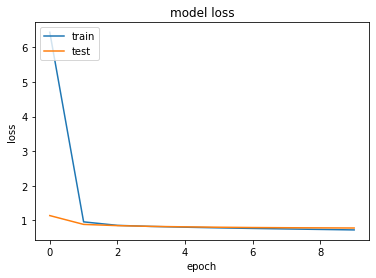

In [ ]:
plt.plot(history1.history["loss"])
plt.plot(history1.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

Now we add neural network to our model with a dropout and concatenatation

Actually I tried with more dense layers and dropouts but it didn't further improve our score

In [ ]:
from keras.layers import Activation, Concatenate, Dense, Dropout


def NNmodel(n_users, n_movies, embedding_size=50):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, embedding_size)(user)
    
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, embedding_size)(movie)
    
    # Concat on the embedding layers and dropout layer
    interaction = Concatenate()([u, m])
    interaction = Dropout(0.05)(interaction)

    # Dense layer with relu and sigmoid activation functions for interaction    
    interaction = Dense(10, kernel_initializer='he_normal')(interaction)
    interaction = Activation('relu')(interaction)
    interaction = Dropout(0.5)(interaction)
    
    interaction = Dense(1, kernel_initializer='he_normal')(interaction)
    interaction = Activation('sigmoid')(interaction)

    # Again used Adam with lr=0.001
    NNmodel = Model(inputs=[user, movie], outputs=interaction)
    opt = Adam(learning_rate=0.001)
    NNmodel.compile(loss='mean_squared_error', optimizer=opt)

    return NNmodel

In [ ]:
model2 = NNmodel(n_users, n_movies)
model2.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_16 (Embedding)       (None, 1, 50)        302000      ['input_17[0][0]']               
                                                                                                  
 embedding_17 (Embedding)       (None, 1, 50)        185300      ['input_18[0][0]']               
                                                                                            

In [ ]:
history2 = model2.fit(x=X_train_array, 
                      y=y_train, 
                      batch_size=1000, 
                      epochs=10, 
                      verbose=1, 
                      validation_data=(X_test_array, y_test))

Epoch 1/10
901/901 [==============================] - 9s 10ms/step - loss: 7.9562 - val_loss: 7.8869
Epoch 2/10
901/901 [==============================] - 8s 9ms/step - loss: 7.9441 - val_loss: 7.8864
Epoch 3/10
901/901 [==============================] - 8s 9ms/step - loss: 7.9352 - val_loss: 7.8860
Epoch 4/10
901/901 [==============================] - 8s 9ms/step - loss: 7.9288 - val_loss: 7.8857
Epoch 5/10
901/901 [==============================] - 8s 9ms/step - loss: 7.9243 - val_loss: 7.8855
Epoch 6/10
901/901 [==============================] - 8s 9ms/step - loss: 7.9215 - val_loss: 7.8854
Epoch 7/10
901/901 [==============================] - 9s 10ms/step - loss: 7.9195 - val_loss: 7.8853
Epoch 8/10
901/901 [==============================] - 8s 9ms/step - loss: 7.9182 - val_loss: 7.8852
Epoch 9/10
901/901 [==============================] - 8s 8ms/step - loss: 7.9173 - val_loss: 7.8852
Epoch 10/10
901/901 [==============================] - 8s 9ms/step - loss: 7.9167 - val_loss: 7.88

In [ ]:
plt.plot(history2.history["loss"])
plt.plot(history2.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

Now final trick

We will try to normalize our target and let's see what will our NNmodel do

Normalize the target between 0 and 1. Makes it easy to train.

In [ ]:

y2 = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Again split data
X_train, X_test, y2_train, y2_test = train_test_split(X, y2, train_size=0.9, random_state=10)

X_train.shape, X_test.shape, y2_train.shape, y2_test.shape




((900188, 2), (100021, 2), (900188,), (100021,))

In [ ]:
model3 = NNmodel(n_users, n_movies)
model3.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_20 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_18 (Embedding)       (None, 1, 50)        302000      ['input_19[0][0]']               
                                                                                                  
 embedding_19 (Embedding)       (None, 1, 50)        185300      ['input_20[0][0]']               
                                                                                            

In [ ]:
history3 = model3.fit(x=X_train_array, 
                      y=y2_train, 
                      batch_size=1000, 
                      epochs=10, 
                      verbose=1, 
                      validation_data=(X_test_array, y2_test))

Epoch 1/10
901/901 [==============================] - 9s 9ms/step - loss: 0.0613 - val_loss: 0.0522
Epoch 2/10
901/901 [==============================] - 8s 9ms/step - loss: 0.0554 - val_loss: 0.0519
Epoch 3/10
901/901 [==============================] - 8s 9ms/step - loss: 0.0549 - val_loss: 0.0517
Epoch 4/10
901/901 [==============================] - 8s 9ms/step - loss: 0.0547 - val_loss: 0.0518
Epoch 5/10
901/901 [==============================] - 8s 9ms/step - loss: 0.0547 - val_loss: 0.0517
Epoch 6/10
901/901 [==============================] - 8s 9ms/step - loss: 0.0546 - val_loss: 0.0517
Epoch 7/10
901/901 [==============================] - 8s 9ms/step - loss: 0.0547 - val_loss: 0.0516
Epoch 8/10
901/901 [==============================] - 8s 9ms/step - loss: 0.0546 - val_loss: 0.0517
Epoch 9/10
901/901 [==============================] - 8s 9ms/step - loss: 0.0546 - val_loss: 0.0516
Epoch 10/10
901/901 [==============================] - 8s 9ms/step - loss: 0.0545 - val_loss: 0.0516

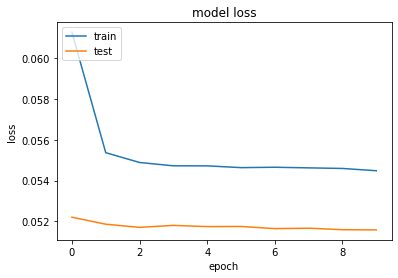

In [ ]:
plt.plot(history3.history["loss"])
plt.plot(history3.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()